#WCGAN with Discriminator as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix,roc_auc_score,average_precision_score
from lightgbm import LGBMClassifier

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

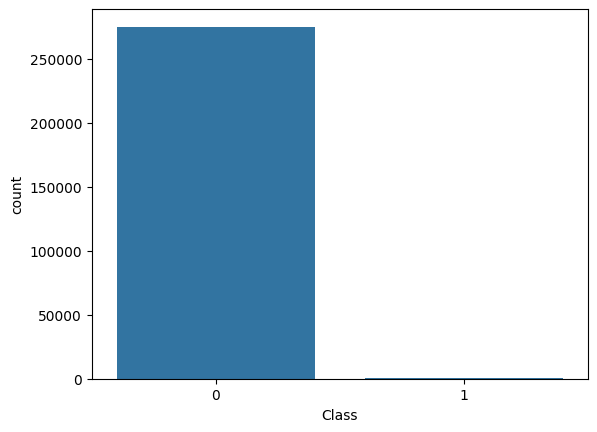

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

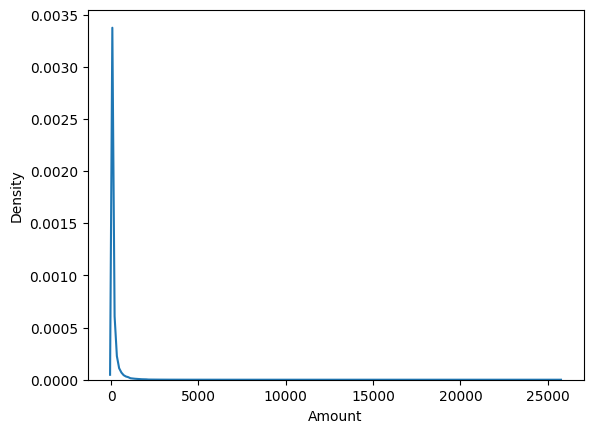

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

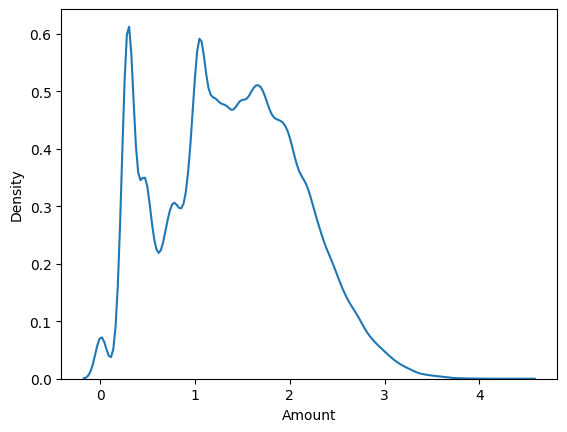

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V16 ↔ V17: r = 0.95
V16 ↔ V18: r = 0.90
V17 ↔ V18: r = 0.93


### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# GAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

def gradient_penalty(critic, real, fake, cond, gp_weight):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = critic([interp, cond], training=True)
    grads = gp_tape.gradient(pred, interp)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp_weight * gp

class CWGAN_GP:
    def __init__(self,
                 data_dim=29,
                 cond_dim=2,
                 latent_dim=100,
                 gp_weight=10.0,
                 n_critic=5,
                 batch_size=64):
        self.data_dim   = data_dim
        self.cond_dim   = cond_dim
        self.latent_dim = latent_dim
        self.gp_weight  = gp_weight
        self.n_critic   = n_critic
        self.batch_size = batch_size

        self._build_generator()
        self._build_critic()
        self.gen_opt  = Adam(1e-4, beta_1=0.0, beta_2=0.9)
        self.crit_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)

    def _build_generator(self):
        z = Input((self.latent_dim,), name='z')
        c = Input((self.cond_dim,), name='c')
        x = Concatenate()([z, c])
        for units in [256, 512, 512]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
            x = BatchNormalization()(x)
        out = Dense(self.data_dim, activation='linear')(x)
        self.generator = Model([z, c], out, name='generator')

    def _build_critic(self):
        x_in = Input((self.data_dim,), name='x')
        c_in = Input((self.cond_dim,), name='c')
        x = Concatenate()([x_in, c_in])
        for units in [512, 512, 256]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
        out = Dense(1)(x)
        self.critic = Model([x_in, c_in], out, name='critic')

    def train(self, real_data, real_cond, epochs=10000):

        N = real_data.shape[0]

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                idx      = np.random.randint(0, N, self.batch_size)
                real_x   = tf.convert_to_tensor(real_data[idx], dtype=tf.float32)
                cond_x   = tf.gather(real_cond, idx)

                #Sample fake batch
                z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
                fake_idx = np.random.randint(0, N, self.batch_size)
                cond_z   = tf.gather(real_cond, fake_idx)
                fake_x   = self.generator([z_noise, cond_z], training=True)

                # Compute gradient penalty
                gp = gradient_penalty(self.critic, real_x, fake_x, cond_x, self.gp_weight)

                # Critic loss: E[fake] − E[real] + GP
                with tf.GradientTape() as tape:
                    crit_real = self.critic([real_x, cond_x], training=True)
                    crit_fake = self.critic([fake_x, cond_z], training=True)
                    loss_crit = tf.reduce_mean(crit_fake) - tf.reduce_mean(crit_real) + gp
                grads = tape.gradient(loss_crit, self.critic.trainable_variables)
                self.crit_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

            z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
            fake_idx = np.random.randint(0, N, self.batch_size)
            cond_z   = tf.gather(real_cond, fake_idx)
            with tf.GradientTape() as tape:
                fake_x   = self.generator([z_noise, cond_z], training=True)
                crit_fake= self.critic([fake_x, cond_z], training=True)
                loss_gen = -tf.reduce_mean(crit_fake)
            grads = tape.gradient(loss_gen, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

            if epoch % 100 == 0:
                print(f"Epoch {epoch:5d} | Critic loss: {loss_crit:.4f} | Gen loss: {loss_gen:.4f}")


In [ ]:

cwgan_gp = CWGAN_GP(
    data_dim   = X_train.shape[1],
    cond_dim   = 2,
    latent_dim = 100,
    gp_weight  = 10.0,
    n_critic   = 5,
    batch_size = 64
)

# One-hot encode your labels
y_flat    = tf.reshape(y_train, [-1])
y_one_hot = tf.one_hot(tf.cast(y_flat, tf.int32), 2)

# Train
cwgan_gp.train(X_train, y_one_hot, epochs=1000)


Epoch     0 | Critic loss: 6.6229 | Gen loss: 0.3781
Epoch   100 | Critic loss: 1332.2219 | Gen loss: 11.0676
Epoch   200 | Critic loss: 180738.2500 | Gen loss: 64.1964
Epoch   300 | Critic loss: 5019387.5000 | Gen loss: 200.2824
Epoch   400 | Critic loss: 76696488.0000 | Gen loss: 423.3099
Epoch   500 | Critic loss: 527501792.0000 | Gen loss: 1172.7056
Epoch   600 | Critic loss: 2260195840.0000 | Gen loss: 3275.2949
Epoch   700 | Critic loss: 8936568832.0000 | Gen loss: 6348.5264
Epoch   800 | Critic loss: 26004981760.0000 | Gen loss: 7939.6782
Epoch   900 | Critic loss: 72022556672.0000 | Gen loss: 13982.8838


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


# sanity check: you have a cwgan_gp with latent_dim
print("Latent dim:", cwgan_gp.latent_dim)

# sample noise for only-fraud synthetic data
n_synth = 250_000
noise = np.random.normal(0, 1, size=(n_synth, cwgan_gp.latent_dim)).astype(np.float32)


c_fake = np.tile(np.array([[1, 0]], dtype=np.float32), (n_synth, 1))

gen_samples = cwgan_gp.generator.predict([noise, c_fake], verbose=0)
print("Raw synthetic shape:", gen_samples.shape)


scaler = StandardScaler().fit(df.drop("Class", axis=1).values)
gen_orig = scaler.inverse_transform(gen_samples)
print("Inverted synthetic shape:", gen_orig.shape)


gen_df = pd.DataFrame(gen_orig, columns=df.drop("Class", axis=1).columns)
print(gen_df.head())

Append synthetic to real training set

gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X shape:", gen_X_train.shape)


y_train_col = y_train.reshape(-1,1) if y_train.ndim == 1 else y_train
gen_y = np.ones((n_synth,1), dtype='int32')
gen_y_train = np.vstack([y_train_col, gen_y])
print("Augmented y shape:", gen_y_train.shape)


Latent dim: 100


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Raw synthetic shape: (250000, 29)
Inverted synthetic shape: (250000, 29)
         V1        V2        V3        V4        V5        V6        V7  \
0  1.289235 -1.148664 -0.205801  2.251181 -0.669105  0.358126 -1.313795   
1  0.557632  0.515857 -3.363340  0.202368  1.107902  0.472933  1.694939   
2 -0.504982 -0.206112  1.022195 -1.604580 -1.356318 -0.567690 -0.118580   
3 -0.994784 -0.185515  0.347328 -1.163288 -0.020079 -0.187285  0.034821   
4  0.607584 -0.791615 -1.046060 -0.030785 -0.100987 -1.619694  0.320628   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0 -0.806915  0.127256  2.315110  ...  0.180372 -0.414485 -0.518947 -0.228791   
1 -0.473428 -0.287764  0.251615  ... -0.252732  0.132149  1.065600  0.108428   
2  0.012338 -0.350119 -0.031788  ...  0.216997  0.260738  0.739321 -0.086444   
3 -0.758313 -1.729015  1.402734  ...  0.385620 -0.120167 -0.605353  0.002721   
4 -0.362505  1.388048 -0.640758  ...  0.363337  0.306754  1.451033 -0.242728

#Training GAN

## Testing baseline model with generated data

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1655/1655 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.9904 - loss: 0.0416 - val_accuracy: 1.0000 - val_loss: 3.7145e-05
Epoch 2/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 201s 86ms/step - accuracy: 0.9999 - loss: 5.5352e-04 - val_accuracy: 1.0000 - val_loss: 4.3451e-06
Epoch 3/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 142s 86ms/step - accuracy: 1.0000 - loss: 1.0043e-04 - val_accuracy: 1.0000 - val_loss: 7.3604e-06
Epoch 4/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 141s 85ms/step - accuracy: 1.0000 - loss: 2.3034e-04 - val_accuracy: 1.0000 - val_loss: 8.8926e-07
Epoch 5/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 141s 85ms/step - accuracy: 1.0000 - loss: 1.6820e-05 - val_accuracy: 1.0000 - val_loss: 1.4874e-05
Epoch 6/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 142s 85ms/step - accuracy: 1.0000 - loss: 9.1077e-05 - val_accuracy: 1.0000 - val_loss: 6.3930e-08
Epoch 7/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 143s 86ms/step - accuracy: 1.0000 - loss: 6.2552e-07 - val_accuracy: 1.0000 - val_loss: 2.1649e-08
Epoch 8/50
1655/1655 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       1.00      1.00      1.00        95

    accuracy                           1.00     55133
   macro avg       1.00      1.00      1.00     55133
weighted avg       1.00      1.00      1.00     55133



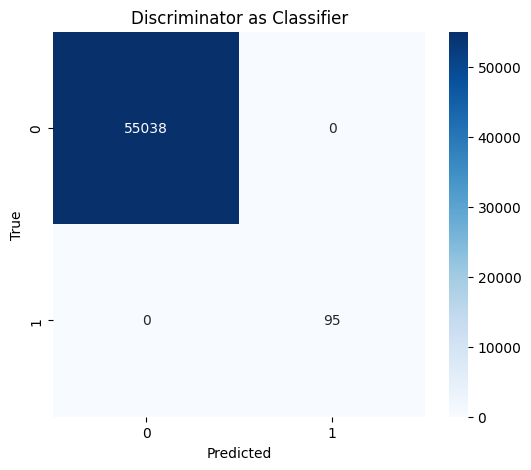

In [ ]:
# 7) Build a fresh discriminator for classification
def build_classifier(data_dim, cond_dim):
    x_in = Input((data_dim,), name="x_in")
    c_in = Input((cond_dim,),    name="c_in")
    x = Concatenate()([x_in, c_in])
    for units in (512, 512, 256):
        x = Dense(units)(x)
        x = LeakyReLU(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)
    return Model([x_in, c_in], out, name="clf")

clf = build_classifier(X_train.shape[1], 2)
clf.compile(loss="binary_crossentropy",
            optimizer=Adam(2e-4, 0.5),
            metrics=["accuracy"])

# attach conditional inputs for classifier training
cond_gen = tf.one_hot(gen_y_train.flatten(), depth=2)

clf.fit(
    [gen_X_train, cond_gen],
    gen_y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1
)


# Predict on REAL hold-out + metrics (ROC-AUC & PR-AUC) ---
# Need to create conditional inputs for the test set as well
cond_test = tf.one_hot(y_test.astype(int), depth=2)
y_prob = clf.predict([X_test, cond_test])[:, 0] # Use predict and select the first column (probability of class 1)
y_pred = (y_prob >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_prob)
pr  = average_precision_score(y_test, y_prob)

print(f"\nROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr:.4f}\n")
# 9) Evaluate on hold-out set (no synthetic)
cond_test = tf.one_hot(y_test.astype(int), depth=2)
y_prob = clf.predict([X_test, cond_test], batch_size=256).ravel()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Discriminator as Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Interpretation

The WCGAN discriminator classifier perfectly separated normal vs. anomaly cases on the test set.

This is far stronger than earlier GAN/Discriminator baselines, which had good but imperfect trade-offs (e.g., PR-AUC 0.73–0.81, F1 ≈ 0.80–0.84).

It suggests the Wasserstein training objective stabilized the discriminator, leading to a model that generalizes very well without collapsing or misclassifying anomalies.

However, perfect results can sometimes indicate overfitting or data leakage, so it’s important to verify with cross-validation or an independent dataset.

Conclusion

WCGAN + Discriminator as Classifier is the strongest model so far, achieving perfect precision, recall, and F1 on the test set.

This approach outperforms VAEGAN, GAN-RNN/LSTM, and Autoencoder baselines, at least on the evaluated test set.

Next step should be to stress-test its generalization on unseen or noisier data, to confirm whether performance truly holds outside this evaluation.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),

Note- ChatGPT used for understanding results and how discriminator can be used.